In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import accuracy_score

N = 1000
alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)
z = np.ones(N)

# past is encoded
past_tense = open("wickle_train/ed1000.txt", 'r').read().strip().split()
words = [pt[:len(pt)-2] for pt in past_tense]

test_past_tense = past_tense[:100]
test_words = words[:100]

past_tense = past_tense[100:]
words = words[100:]


RI_pres = np.random.rand(D, N)
RI_pres = np.where(RI_pres>0.5, 1, -1)

RI_past = np.random.rand(D, N)
RI_past = np.where(RI_past>0.5, 1, -1)

In [13]:
def ngram_encode(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

def encodes(words, past_tense):
    seen = []
    for i in range(len(words)):
        enc = ngram_encode_cl(words[i], RI_pres, 3)
        enc_past = ngram_encode_cl(past_tense[i], RI_past, 3)
        seen.append((enc, enc_past))
    return seen

def map_train(encoded, reg=1):
    total_vec = np.zeros(N) #psi
    for i in range(len(encoded)):
        total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def no_reg_perceptron_map_train(encoded, reg=1):
    total_vec = np.zeros(N) #psi
    for i in range(len(encoded)):
        # if predict correctly, add to total_vec with a smaller weight
        train_pred, random_pred = predict(total_vec, [encoded[i]])
        if train_pred > random_pred:
            total_vec += ((N-train_pred)/float(N)) * np.multiply(encoded[i][0], encoded[i][1])
        else:
            total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def perceptron_map_train(encoded, reg=1):
    total_vec = np.zeros(N) #psi
    for i in range(len(encoded)):
        # if predict correctly, add to total_vec with a smaller weight
        train_pred, random_pred = predict(total_vec, [encoded[i]])
        if train_pred > random_pred:
            # trying different regularization values
            #total_vec += (1/float(i)) * np.multiply(encoded[i][0], encoded[i][1])
            #total_vec += .5 * np.multiply(encoded[i][0], encoded[i][1])
            total_vec += (1/float(train_pred*reg + 1e-10)) * np.multiply(encoded[i][0], encoded[i][1]) #BEST
        else:
            total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def abs_perceptron_map_train(encoded, reg=1):
    total_vec = np.zeros(N) #psi
    for i in range(len(encoded)):
        # if predict correctly, add to total_vec with a smaller weight
        train_pred, random_pred = predict(total_vec, [encoded[i]])
        if train_pred > random_pred:
            total_vec += (1/float(abs(train_pred*reg + 1e-10))) * np.multiply(encoded[i][0], encoded[i][1]) #BEST
        else:
            total_vec += np.multiply(encoded[i][0], encoded[i][1])
    return total_vec

def predict(model, encoded):
    data1, data3 = np.zeros(len(encoded)), np.zeros(len(encoded))
    total1, total3, count = 0, 0, 0
    
    random_vecs = np.random.randn(len(encoded), N)
    
    for j in range(len(encoded)):
        pair = encoded[j]
        sim1 = np.dot(np.multiply(model, pair[0]), pair[1])
        total1 += sim1

        sim3 = np.dot(np.multiply(model, random_vecs[j,:]), pair[0])
        total3 += sim3

        count += 1
        data1[j] = sim1 #total1/float(count)
        data3[j] = sim3 #total3/float(count)

    return data1, data3

    #plt.figure()
    #plt.plot(data1, label="Average pairwise similarity")
    #plt.ylabel("Average similarity per vector")
    #plt.xlabel("Number of words in model vector")
    #plt.plot(data3, label="Random pairwise similarity")
    #plt.legend(loc=1,prop={'size':10})
    #plt.show()
    

In [6]:
encoded = encodes(words, past_tense)
test_encoded = encodes(test_words, test_past_tense)

def graph(train_func, reg=1):
    test_m = np.arange(1, len(encoded), 1)

    train_dot = np.zeros_like(test_m)
    test_dot = np.zeros_like(test_m) # np.zeros(test_m.shape)
    random_dot = np.zeros_like(test_m)

    for im, m in enumerate(test_m):
        map_model = train_func(encoded[:int(m)], reg)
        d1, d3 = predict(map_model, encoded[:int(m)])
        d2, d4 = predict(map_model, test_encoded)
        train_dot[im] = d1.mean()
        test_dot[im] = d2.mean()
        random_dot[im] = d3.mean()

    plt.figure()
    plt.plot(test_m, train_dot)
    plt.plot(test_m, random_dot)
    plt.plot(test_m, test_dot)
    plt.show()

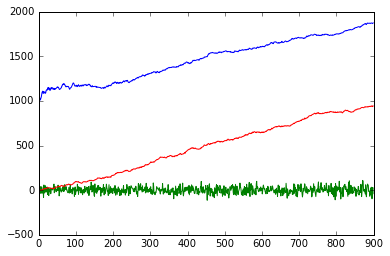

In [7]:
graph(map_train)

1.0


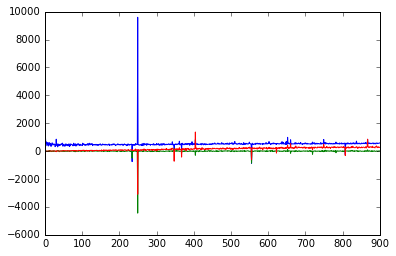

0.989898989899


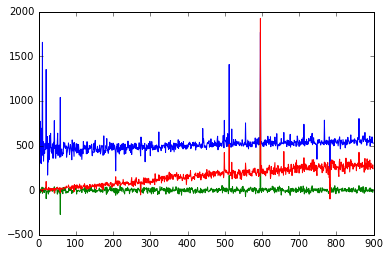

0.979797979798


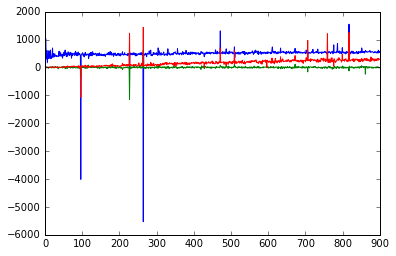

0.969696969697


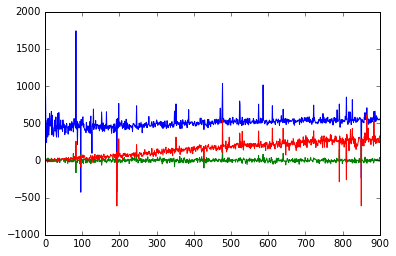

0.959595959596


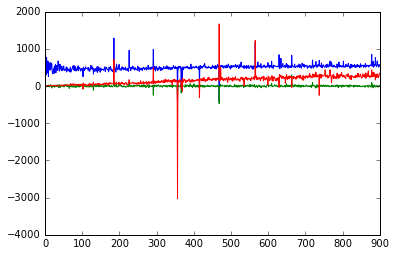

0.949494949495


KeyboardInterrupt: 

In [8]:
regs = np.linspace(0,1,100)
for i in range(regs.shape[0]-1, 0, -1):
    print regs[i]
    graph(perceptron_map_train, regs[i])

1.0


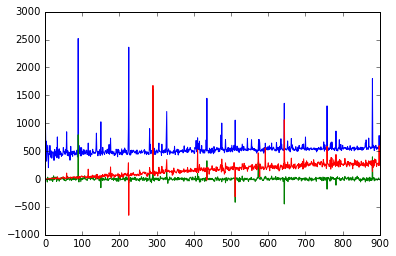

0.989898989899


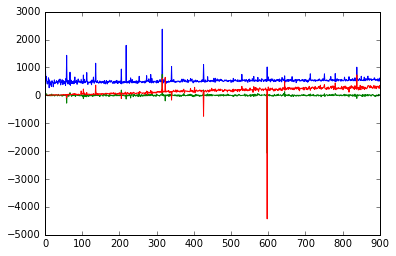

0.979797979798


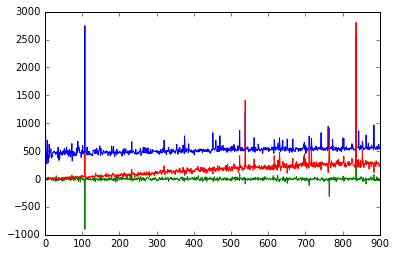

0.969696969697


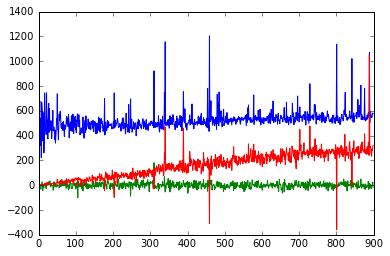

0.959595959596


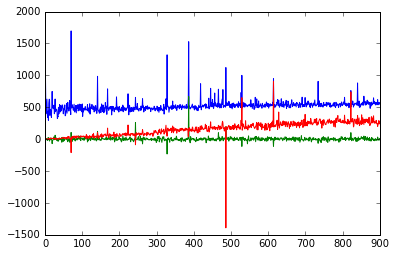

0.949494949495


KeyboardInterrupt: 

In [9]:
regs = np.linspace(0,1,100)
for i in range(regs.shape[0]-1, 0, -1):
    print regs[i]
    graph(abs_perceptron_map_train, regs[i])

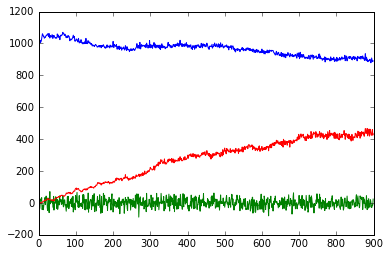

In [14]:
graph(no_reg_perceptron_map_train)